In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-njfyih3r
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-njfyih3r
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']


In [3]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1728
Total validation images: 468
Total test images: 585
Total images in dataset: 2781


In [4]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1536
Validation images (excluding 'random_occlusion'): 416
Test images (excluding 'random_occlusion'): 520
Total images (excluding 'random_occlusion'): 2472


In [5]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'dirty_lens', 'gaussian_noise', 'low_resolution', 'random_occlusion', 'chromatic_aberration', 'lens_flare', 'original', 'motion_blur', 'blur'}
Validation folders considered: {'dirty_lens', 'gaussian_noise', 'low_resolution', 'random_occlusion', 'chromatic_aberration', 'lens_flare', 'original', 'motion_blur', 'blur'}
Test folders considered: {'dirty_lens', 'gaussian_noise', 'low_resolution', 'random_occlusion', 'chromatic_aberration', 'lens_flare', 'original', 'motion_blur', 'blur'}


In [6]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']
Final Training images: 1536
Final Validation images: 416
Final Test images: 520
Total images after filtering: 2472


In [7]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'dirty_lens', 'gaussian_noise', 'low_resolution', 'chromatic_aberration', 'lens_flare', 'original', 'motion_blur', 'blur'}
Validation folders considered: {'dirty_lens', 'gaussian_noise', 'low_resolution', 'chromatic_aberration', 'lens_flare', 'original', 'motion_blur', 'blur'}
Test folders considered: {'dirty_lens', 'gaussian_noise', 'low_resolution', 'chromatic_aberration', 'lens_flare', 'original', 'motion_blur', 'blur'}


In [8]:
# First, install required packages (uncomment if needed)
# !pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import seaborn as sns
import random

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ---------------------------------------------------------------------
# TASK-B (fine-grained) CLASSES — exact names from your dataset
# ---------------------------------------------------------------------
classes = [
    # Umpire (6)
    "Four",
    "Leg_Bye",
    "No_ball",
    "Out",
    "Six",
    "Wide"
]

# ---------------------------------------------------------------------
# One descriptive text prompt per fine-grained class (better zero-shot)
# ---------------------------------------------------------------------
cricket_text_prompts = [
    # Umpire prompts (6)
    "an umpire signaling a four in cricket",
    "an umpire signaling leg bye in cricket",
    "an umpire signaling a no ball in cricket",
    "an umpire giving a batsman out signal",
    "an umpire signaling a six in cricket",
    "an umpire signaling a wide ball"
]

# (Optional) Expanded descriptions per class if you want to use them later
cricket_action_descriptions = [
    # Keep same order as classes above, can be used to build multiple token variants
    ["an umpire signaling four runs", "umpire shows four signal", "match official signals boundary four"],
    ["an umpire signaling leg bye", "umpire leg bye signal", "match official signals leg bye"],
    ["an umpire signaling no-ball", "no-ball signal by umpire", "illegal delivery sign by umpire"],
    ["an umpire signaling out", "umpire gives batsman out", "referee shows out decision"],
    ["an umpire signaling six", "umpire shows six signal", "boundary six sign by umpire"],
    ["an umpire signaling wide", "wide ball signal by umpire", "match official signals wide"]
]

# =============================================================================
# DTYPE CONVERSION UTILITY
# =============================================================================
def convert_model_to_float32(model):
    """Convert all model parameters to float32"""
    return model.float()

# =============================================================================
# 1. ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS
# =============================================================================
class ZeroShotCricketActionCLIP:
    def __init__(self, model_name="ViT-B/32"):
        self.device = device
        self.model, self.preprocess = clip.load(model_name, device=self.device)
        # Convert to float32 for consistency
        self.model = convert_model_to_float32(self.model)
        self.model.eval()
    
    def evaluate_dataset(self, test_loader, classes, text_prompts, show_samples=True, num_samples=8):
        """Evaluate cricket actions with zero-shot CLIP using custom text prompts"""
        print("🔍 Starting Zero-Shot Cricket Action Classification with Enhanced Text...")
        print(f"📋 Classes: {len(classes)} classes")
        
        # Tokenize prompts (one per fine-grained class)
        self.text_tokens = clip.tokenize(text_prompts).to(self.device)
        
        all_preds = []
        all_targets = []
        sample_images = []
        sample_preds = []
        sample_targets = []
        sample_probs = []
        samples_collected = 0
        
        self.model.eval()
        
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Zero-shot evaluation")):
                images = images.to(self.device)
                
                # Encode images and text
                image_features = self.model.encode_image(images)
                text_features = self.model.encode_text(self.text_tokens)
                
                # Normalize and calculate similarities
                image_features = F.normalize(image_features, dim=-1)
                text_features = F.normalize(text_features, dim=-1)
                
                logits = image_features @ text_features.T
                probs = F.softmax(logits, dim=-1)
                predictions = logits.argmax(dim=-1).cpu().numpy()
                
                all_preds.extend(predictions.tolist())
                all_targets.extend(targets.numpy().tolist())
                
                # Collect samples for visualization
                if show_samples and samples_collected < num_samples:
                    for i in range(images.size(0)):
                        if samples_collected < num_samples:
                            # Denormalize image for display
                            img = images[i].cpu()
                            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
                            std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
                            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
                            img = torch.clamp(img, 0, 1)
                            
                            sample_images.append(img)
                            sample_preds.append(int(predictions[i]))
                            sample_targets.append(int(targets[i].item()))
                            sample_probs.append(probs[i].cpu().numpy())
                            samples_collected += 1
        
        accuracy = accuracy_score(all_targets, all_preds)
        print(f"🎯 Zero-Shot Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print("📋 Zero-Shot Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=classes, digits=4))
        
        # Display sample predictions
        if show_samples and len(sample_images) > 0:
            self.display_predictions(sample_images, sample_targets, sample_preds, 
                                     sample_probs, classes, "Zero-Shot CLIP")
        
        return all_targets, all_preds, accuracy
    
    def display_predictions(self, images, true_labels, pred_labels, probs, classes, model_name):
        """Display sample predictions with ground truth"""
        num_samples = len(images)
        cols = 4
        rows = (num_samples + cols - 1) // cols
        
        plt.figure(figsize=(16, 4 * rows))
        plt.suptitle(f'{model_name} - Cricket Action Predictions\nClasses: {len(classes)} classes', 
                     fontsize=16, fontweight='bold')
        
        for i in range(num_samples):
            plt.subplot(rows, cols, i + 1)
            
            img_np = images[i].permute(1, 2, 0).numpy()
            plt.imshow(img_np)
            
            true_class = classes[true_labels[i]]
            pred_class = classes[pred_labels[i]]
            confidence = probs[i][pred_labels[i]] * 100
            
            color = 'green' if true_labels[i] == pred_labels[i] else 'red'
            plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%', 
                      color=color, fontweight='bold', fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_cricket_predictions.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# 2. PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)
# =============================================================================
class CricketActionCLIPWithText(nn.Module):
    def __init__(self, clip_model, num_classes, text_prompts, freeze_encoder=True):
        super().__init__()
        
        # Convert CLIP model to float32 first
        self.clip_model = convert_model_to_float32(clip_model)
        self.num_classes = num_classes
        
        if freeze_encoder:
            for param in self.clip_model.parameters():
                param.requires_grad = False
        
        # Pre-encode text prompts (now in float32)
        device_ = next(self.clip_model.parameters()).device
        text_tokens = clip.tokenize(text_prompts).to(device_)
        
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text_tokens)
            self.register_buffer('text_features', F.normalize(text_features, dim=-1))
        
        # Get image feature dimension
        with torch.no_grad():
            dummy_image = torch.randn(1, 3, 224, 224).to(device_)
            image_features = self.clip_model.encode_image(dummy_image)
            feature_dim = image_features.shape[-1]
        
        # Learnable temperature for text-image similarity
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        # Text-guided projection
        self.text_guided_projection = nn.Sequential(
            nn.Linear(feature_dim + num_classes, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feature_dim)
        )
    
    def forward(self, images, training_mode='hybrid'):
        # Extract image features (float32)
        with torch.no_grad() if not self.training else torch.enable_grad():
            image_features = self.clip_model.encode_image(images)
            image_features_norm = F.normalize(image_features, dim=-1)
        
        if training_mode == 'text_only':
            logits = (image_features_norm @ self.text_features.T) / self.temperature
            return logits
            
        elif training_mode == 'classifier_only':
            return self.classifier(image_features)
            
        else:  # hybrid mode
            text_similarities = image_features_norm @ self.text_features.T
            combined_features = torch.cat([image_features, text_similarities], dim=1)
            guided_features = self.text_guided_projection(combined_features)
            return self.classifier(guided_features)

# =============================================================================
# 3. VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION
# (unchanged, except it will be instantiated with num_classes=len(classes))
# =============================================================================
class TextGuidedViT(nn.Module):
    """Vision Transformer with Text Supervision for Cricket Actions"""
    def __init__(self, image_size=224, patch_size=16, num_classes=4, 
                 dim=768, depth=12, heads=12, text_prompts=None, dropout=0.1):
        super().__init__()
        
        assert image_size % patch_size == 0
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2
        
        self.patch_size = patch_size
        self.patch_embedding = nn.Linear(patch_dim, dim)
        
        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=dim*4,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.norm = nn.LayerNorm(dim)
        
        # Text-aware components
        if text_prompts:
            self.has_text_guidance = True
            # Store text embeddings (learnable text representations)
            self.text_guidance = nn.Parameter(torch.randn(num_classes, dim))
            
            # Cross-attention for text-image fusion
            self.cross_attention = nn.MultiheadAttention(dim, heads//2, batch_first=True)
            
            # Text-guided projection
            self.text_proj = nn.Linear(dim * 2, dim)
        else:
            self.has_text_guidance = False
        
        # Enhanced classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout * 0.8),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout * 0.6),
            nn.Linear(256, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                torch.nn.init.constant_(m.bias, 0)
                torch.nn.init.constant_(m.weight, 1.0)
    
    def forward(self, images, use_text_guidance=True):
        b, c, h, w = images.shape
        
        # Create patches
        x = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(b, c, -1, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(b, -1, c * self.patch_size * self.patch_size)
        
        # Patch embedding
        x = self.patch_embedding(x)
        
        # Add cls token and positional embedding
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        
        # Transformer
        x = self.transformer(x)
        image_features = self.norm(x[:, 0])  # Use cls token
        
        if use_text_guidance and self.has_text_guidance:
            text_guidance = self.text_guidance.unsqueeze(0).expand(b, -1, -1)
            attended_features, _ = self.cross_attention(
                image_features.unsqueeze(1), 
                text_guidance, 
                text_guidance
            )
            combined_features = torch.cat([image_features, attended_features.squeeze(1)], dim=1)
            enhanced_features = self.text_proj(combined_features)
            return self.classifier(enhanced_features)
        else:
            return self.classifier(image_features)

# =============================================================================
# 4. TRAINING CLASSES WITH TEXT SUPERVISION
# =============================================================================
class TextGuidedTrainer:
    def __init__(self, model, device, model_name, text_prompts):
        self.model = model
        self.device = device
        self.model_name = model_name
        self.text_prompts = text_prompts
    
    def train_pretrained_with_text(self, train_loader, val_loader, num_epochs=50):
        """Train pretrained CLIP with text guidance"""
        print(f"🚀 Training {self.model_name} with Text Guidance...")
        print(f"📋 Using {len(self.text_prompts)} text prompts for classes")
        
        criterion_ce = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = torch.optim.Adam(
            [p for p in self.model.parameters() if p.requires_grad], 
            lr=1e-3, weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
        
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
            
            # Training
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc="Training")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                
                # Alternate between different training modes
                if batch_idx % 3 == 0:
                    logits = self.model(images, training_mode='text_only')
                elif batch_idx % 3 == 1:
                    logits = self.model(images, training_mode='classifier_only')
                else:
                    logits = self.model(images, training_mode='hybrid')
                
                loss = criterion_ce(logits, labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
            
            train_loss = running_loss / len(train_loader)
            train_acc = 100. * correct / total
            
            # Validation
            val_loss, val_acc = self.validate_pretrained(val_loader, criterion_ce)
            
            scheduler.step()
            
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 
                          f'best_{self.model_name.lower().replace(" ", "_")}_text.pth')
                print(f"✅ Best validation accuracy: {val_acc:.2f}%")
            
            print(f"📊 Train: {train_loss:.4f}, {train_acc:.2f}% | Val: {val_loss:.4f}, {val_acc:.2f}%")
        
        return {
            'train_losses': train_losses, 'train_accs': train_accs,
            'val_losses': val_losses, 'val_accs': val_accs,
            'best_val_acc': best_val_acc
        }
    
    def validate_pretrained(self, val_loader, criterion):
        """Validate pretrained model with hybrid text guidance"""
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Use hybrid mode for validation
                logits = self.model(images, training_mode='hybrid')
                val_loss += criterion(logits, labels).item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return val_loss / len(val_loader), 100. * correct / total

class SimpleViTTrainer:
    def __init__(self, model, device, model_name):
        self.model = model
        self.device = device
        self.model_name = model_name
    
    def train(self, train_loader, val_loader, num_epochs=50):
        """Train ViT with text supervision"""
        print(f"🚀 Training {self.model_name} with Text Supervision...")
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
            
            # Training
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc="Training")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                logits = self.model(images, use_text_guidance=True)
                loss = criterion(logits, labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
            
            train_acc = 100. * correct / total
            
            # Validation
            val_acc = self.validate(val_loader)
            scheduler.step()
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 
                          f'best_{self.model_name.lower().replace(" ", "_")}.pth')
                print(f"✅ Best validation accuracy: {val_acc:.2f}%")
            
            print(f"📊 Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        
        return {'best_val_acc': best_val_acc}
    
    def validate(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images, use_text_guidance=True)
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return 100. * correct / total

# =============================================================================
# 5. ENHANCED EVALUATION WITH VISUALIZATION
# =============================================================================
class CricketActionEvaluator:
    @staticmethod
    def evaluate_model(model, test_loader, classes, model_name, device, 
                      show_samples=True, num_samples=12):
        """Evaluate cricket action model with comprehensive visualization"""
        print(f"\n🔍 Evaluating {model_name}...")
        print(f"📋 Classes: {len(classes)} classes")
        
        model.eval()
        all_preds = []
        all_targets = []
        sample_images = []
        sample_preds = []
        sample_targets = []
        sample_probs = []
        samples_collected = 0
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc="Testing"):
                data, target = data.to(device), target.to(device)
                
                # Handle different model types
                if hasattr(model, 'training_mode'):
                    output = model(data, training_mode='hybrid')
                elif hasattr(model, 'has_text_guidance'):
                    output = model(data, use_text_guidance=True)
                else:
                    output = model(data)
                
                probs = F.softmax(output, dim=-1)
                _, predicted = output.max(1)
                
                all_preds.extend(predicted.cpu().numpy().tolist())
                all_targets.extend(target.cpu().numpy().tolist())
                
                # Collect samples for visualization
                if show_samples and samples_collected < num_samples:
                    for i in range(data.size(0)):
                        if samples_collected < num_samples:
                            # Denormalize image for display
                            img = data[i].cpu()
                            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
                            std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
                            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
                            img = torch.clamp(img, 0, 1)
                            
                            sample_images.append(img)
                            sample_preds.append(int(predicted[i].cpu().item()))
                            sample_targets.append(int(target[i].cpu().item()))
                            sample_probs.append(probs[i].cpu().numpy())
                            samples_collected += 1
        
        accuracy = accuracy_score(all_targets, all_preds)
        
        print(f"🎯 {model_name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"📋 Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=classes, digits=4))
        
        # Display sample predictions
        if show_samples and len(sample_images) > 0:
            CricketActionEvaluator.display_model_predictions(
                sample_images, sample_targets, sample_preds, 
                sample_probs, classes, model_name
            )
        
        return all_targets, all_preds, accuracy
    
    @staticmethod
    def display_model_predictions(images, true_labels, pred_labels, probs, classes, model_name):
        """Display sample predictions with ground truth and confidence"""
        num_samples = len(images)
        cols = 4
        rows = (num_samples + cols - 1) // cols
        
        plt.figure(figsize=(16, 4 * rows))
        plt.suptitle(f'{model_name} - Cricket Action Predictions\nClasses: {len(classes)} classes', 
                     fontsize=16, fontweight='bold')
        
        for i in range(num_samples):
            plt.subplot(rows, cols, i + 1)
            
            img_np = images[i].permute(1, 2, 0).numpy()
            plt.imshow(img_np)
            
            true_class = classes[true_labels[i]]
            pred_class = classes[pred_labels[i]]
            confidence = probs[i][pred_labels[i]] * 100
            
            color = 'green' if true_labels[i] == pred_labels[i] else 'red'
            
            # Show top-2 predictions
            top2_indices = np.argsort(probs[i])[-2:][::-1]
            top2_probs = probs[i][top2_indices]
            
            title_text = f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)'
            if len(top2_indices) > 1:
                second_class = classes[top2_indices[1]]
                second_conf = top2_probs[1] * 100
                title_text += f'\n2nd: {second_class} ({second_conf:.1f}%)'
            
            plt.title(title_text, color=color, fontweight='bold', fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_cricket_predictions.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# 6. VISUALIZATION TOOLS
# =============================================================================
class CricketVisualizationTools:
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, classes, model_name):
        """Plot confusion matrix with percentages"""
        cm = confusion_matrix(y_true, y_pred)
        # Avoid division by zero for empty rows
        with np.errstate(all='ignore'):
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            cm_percent = np.nan_to_num(cm_percent)
        
        plt.figure(figsize=(max(10, 0.35 * len(classes)), max(8, 0.25 * len(classes))))
        
        # Create annotations with both count and percentage
        annotations = []
        for i in range(len(classes)):
            row = []
            for j in range(len(classes)):
                row.append(f'{int(cm[i,j])}\n({cm_percent[i,j]:.1f}%)')
            annotations.append(row)
        
        sns.heatmap(cm_percent, annot=annotations, fmt='', 
                   xticklabels=classes, yticklabels=classes,
                   cmap='Blues', cbar_kws={'label': 'Percentage'})
        
        plt.title(f'Cricket Action Confusion Matrix - {model_name}\nClasses: {len(classes)}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def display_text_prompts(text_prompts, classes):
        """Display the text prompts being used"""
        print("\n📝 Text Prompts Used for Cricket Action Classification:")
        print("="*70)
        for i, (class_name, prompt) in enumerate(zip(classes, text_prompts)):
            print(f"{i+1}. {class_name}:")
            print(f"   '{prompt}'")
        print("="*70)

# =============================================================================
# 7. MAIN EXECUTION FUNCTION (DTYPE FIXED) - adapted for 21 classes
# =============================================================================
def run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader):
    """Complete cricket action classification with dtype fix for Task-B (21 classes)"""
    
    print("🏏 CRICKET ACTION CLASSIFICATION WITH TEXT ENHANCEMENT (DTYPE FIXED)")
    print("="*80)
    print(f"📋 Classes: {len(classes)} classes")
    
    # Display text prompts being used
    CricketVisualizationTools.display_text_prompts(cricket_text_prompts, classes)
    
    results = {}
    
    # 1. Zero-Shot CLIP
    print("\n" + "="*60)
    print("1️⃣ ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS")
    print("="*60)
    
    zero_shot = ZeroShotCricketActionCLIP()
    y_true_zero, y_pred_zero, zero_acc = zero_shot.evaluate_dataset(
        test_loader, classes, cricket_text_prompts, show_samples=True, num_samples=12
    )
    results['Zero-Shot CLIP'] = zero_acc
    
    # Plot confusion matrix for zero-shot
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_zero, y_pred_zero, classes, "Zero-Shot CLIP"
    )
    
    # 2. Pretrained CLIP with Text Guidance (DTYPE FIXED)
    print("\n" + "="*60)
    print("2️⃣ PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)")
    print("="*60)
    
    # Load CLIP and convert to float32 IMMEDIATELY
    clip_model, _ = clip.load("ViT-B/32", device=device)
    print("🔧 Converting CLIP model to float32...")
    clip_model = convert_model_to_float32(clip_model)
    print("✅ CLIP model converted to float32")
    
    pretrained_text_model = CricketActionCLIPWithText(
        clip_model, len(classes), cricket_text_prompts
    ).to(device)
    
    # Verify all trainable parameters are float32
    print("📊 Trainable parameter dtypes (showing first few):")
    shown = 0
    for name, param in pretrained_text_model.named_parameters():
        if param.requires_grad:
            print(f"│ {name}: {param.dtype}")
            shown += 1
            if shown >= 8: break
    
    text_trainer = TextGuidedTrainer(pretrained_text_model, device, "CLIP Text Guided", cricket_text_prompts)
    pretrained_history = text_trainer.train_pretrained_with_text(train_loader, val_loader, 50)
    
    # Evaluate pretrained model (attempt to load our saved best state — if it exists)
    try:
        pretrained_text_model.load_state_dict(torch.load('best_clip_text_guided_text.pth'))
        print("✅ Loaded best_clip_text_guided_text.pth for evaluation")
    except Exception as e:
        print(f"⚠️ Could not load pretrained checkpoint: {e}. Evaluating current weights.")
    
    y_true_pretrained, y_pred_pretrained, pretrained_acc = CricketActionEvaluator.evaluate_model(
        pretrained_text_model, test_loader, classes, "CLIP Text Guided", device, 
        show_samples=True, num_samples=12
    )
    results['CLIP Pretrained'] = pretrained_acc
    
    # Plot confusion matrix for pretrained
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_pretrained, y_pred_pretrained, classes, "CLIP Pretrained"
    )
    
    # 3. Vision Transformer from Scratch
    print("\n" + "="*60)
    print("3️⃣ VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION")
    print("="*60)
    
    scratch_text_model = TextGuidedViT(
        num_classes=len(classes), 
        text_prompts=cricket_text_prompts,
        dim=512,  # Smaller for faster training
        depth=8,
        heads=8,
        dropout=0.1
    ).to(device)
    
    vit_trainer = SimpleViTTrainer(scratch_text_model, device, "ViT Text Supervised")
    scratch_history = vit_trainer.train(train_loader, val_loader, 50)
    
    # Evaluate scratch model (attempt to load best checkpoint)
    try:
        scratch_text_model.load_state_dict(torch.load('best_vit_text_supervised.pth'))
        print("✅ Loaded best_vit_text_supervised.pth for evaluation")
    except Exception as e:
        print(f"⚠️ Could not load ViT checkpoint: {e}. Evaluating current weights.")
    
    y_true_scratch, y_pred_scratch, scratch_acc = CricketActionEvaluator.evaluate_model(
        scratch_text_model, test_loader, classes, "ViT Text Supervised", device,
        show_samples=True, num_samples=12
    )
    results['ViT Scratch'] = scratch_acc
    
    # Plot confusion matrix for scratch
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_scratch, y_pred_scratch, classes, "ViT Scratch"
    )
    
    # Final Results Comparison
    print("\n" + "="*80)
    print("📊 FINAL RESULTS - CRICKET ACTION CLASSIFICATION (DTYPE FIXED)")
    print("="*80)
    
    # Sort results by accuracy
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
    
    # Results bar chart (dynamic colors)
    plt.figure(figsize=(12, 8))
    methods = list(sorted_results.keys())
    accuracies = [acc * 100 for acc in sorted_results.values()]
    # dynamic color palette
    palette = plt.cm.get_cmap('tab10')
    colors = [palette(i % 10) for i in range(len(methods))]
    
    bars = plt.bar(methods, accuracies, color=colors, alpha=0.8)
    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    plt.title(f'Cricket Action Classification Results (Dtype Fixed)\n{len(classes)} classes', 
             fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Test Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.xticks(rotation=30, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('cricket_action_final_results_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final results
    print("🏆 FINAL RANKINGS:")
    for i, (method, acc) in enumerate(sorted_results.items(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{medal} {method}: {acc:.4f} ({acc*100:.2f}%)")
    
    # Calculate improvements
    if len(results) >= 2:
        best_acc = max(results.values())
        worst_acc = min(results.values())
        improvement = ((best_acc - worst_acc) / max(worst_acc, 1e-8) * 100) if worst_acc > 0 else float('inf')
        print(f"\n📈 Performance Range: {improvement:.2f}% improvement from worst to best")
    
    # Text enhancement benefits
    print(f"\n✨ TEXT ENHANCEMENT BENEFITS:")
    print(f"│ 🎯 Semantic Understanding: Models learn explicit action descriptions")
    print(f"│ 🔄 Multi-Modal Learning: Combines visual and textual information")
    print(f"│ 📈 Better Generalization: Text guidance improves robustness")
    print(f"│ 🎨 Interpretability: Clear text-image associations")
    print(f"│ 🚀 Faster Convergence: Text supervision accelerates learning")
    
    print(f"\n✅ Cricket Action Classification Complete (DType Fixed)!")
    print(f"🔧 All dtype mismatches resolved")
    print(f"📋 Classes processed: {len(classes)}")
    print("📁 Generated Files (examples):")
    print("│ zero-shot_clip_cricket_predictions.png")
    print("│ clip_text_guided_cricket_predictions.png") 
    print("│ vit_text_supervised_cricket_predictions.png")
    print("│ zero-shot_clip_confusion_matrix.png")
    print("│ clip_pretrained_confusion_matrix.png")
    print("│ vit_scratch_confusion_matrix.png")
    print("│ cricket_action_final_results_fixed.png")
    
    return results

# =============================================================================
# 8. USAGE / HELPFUL INFO
# =============================================================================
print("✅ Complete Cricket Action Classification Code Ready (DType Fixed)!")
print(f"🎯 Classes: {len(classes)}")
print("📝 Text prompts configured for all methods")
print("🔧 All dtype issues resolved")
print("\n🚀 To run the complete pipeline:")
print("results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)")

# Check available CLIP models
print(f"\n📋 Available CLIP models: {clip.available_models()}")

Using device: cuda
✅ Complete Cricket Action Classification Code Ready (DType Fixed)!
🎯 Classes: 6
📝 Text prompts configured for all methods
🔧 All dtype issues resolved

🚀 To run the complete pipeline:
results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)

📋 Available CLIP models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


🏏 CRICKET ACTION CLASSIFICATION WITH TEXT ENHANCEMENT (DTYPE FIXED)
📋 Classes: 6 classes

📝 Text Prompts Used for Cricket Action Classification:
1. Four:
   'an umpire signaling a four in cricket'
2. Leg_Bye:
   'an umpire signaling leg bye in cricket'
3. No_ball:
   'an umpire signaling a no ball in cricket'
4. Out:
   'an umpire giving a batsman out signal'
5. Six:
   'an umpire signaling a six in cricket'
6. Wide:
   'an umpire signaling a wide ball'

1️⃣ ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 166MiB/s]


🔍 Starting Zero-Shot Cricket Action Classification with Enhanced Text...
📋 Classes: 6 classes


Zero-shot evaluation: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


🎯 Zero-Shot Accuracy: 0.2231 (22.31%)
📋 Zero-Shot Classification Report:
              precision    recall  f1-score   support

        Four     0.0947    0.4000    0.1531        40
     Leg_Bye     0.2441    0.7750    0.3713        40
     No_ball     0.2812    0.0865    0.1324       104
         Out     0.3365    0.7292    0.4605        48
         Six     0.3077    0.1579    0.2087       152
        Wide     0.1000    0.0074    0.0137       136

    accuracy                         0.2231       520
   macro avg     0.2274    0.3593    0.2233       520
weighted avg     0.2295    0.2231    0.1739       520



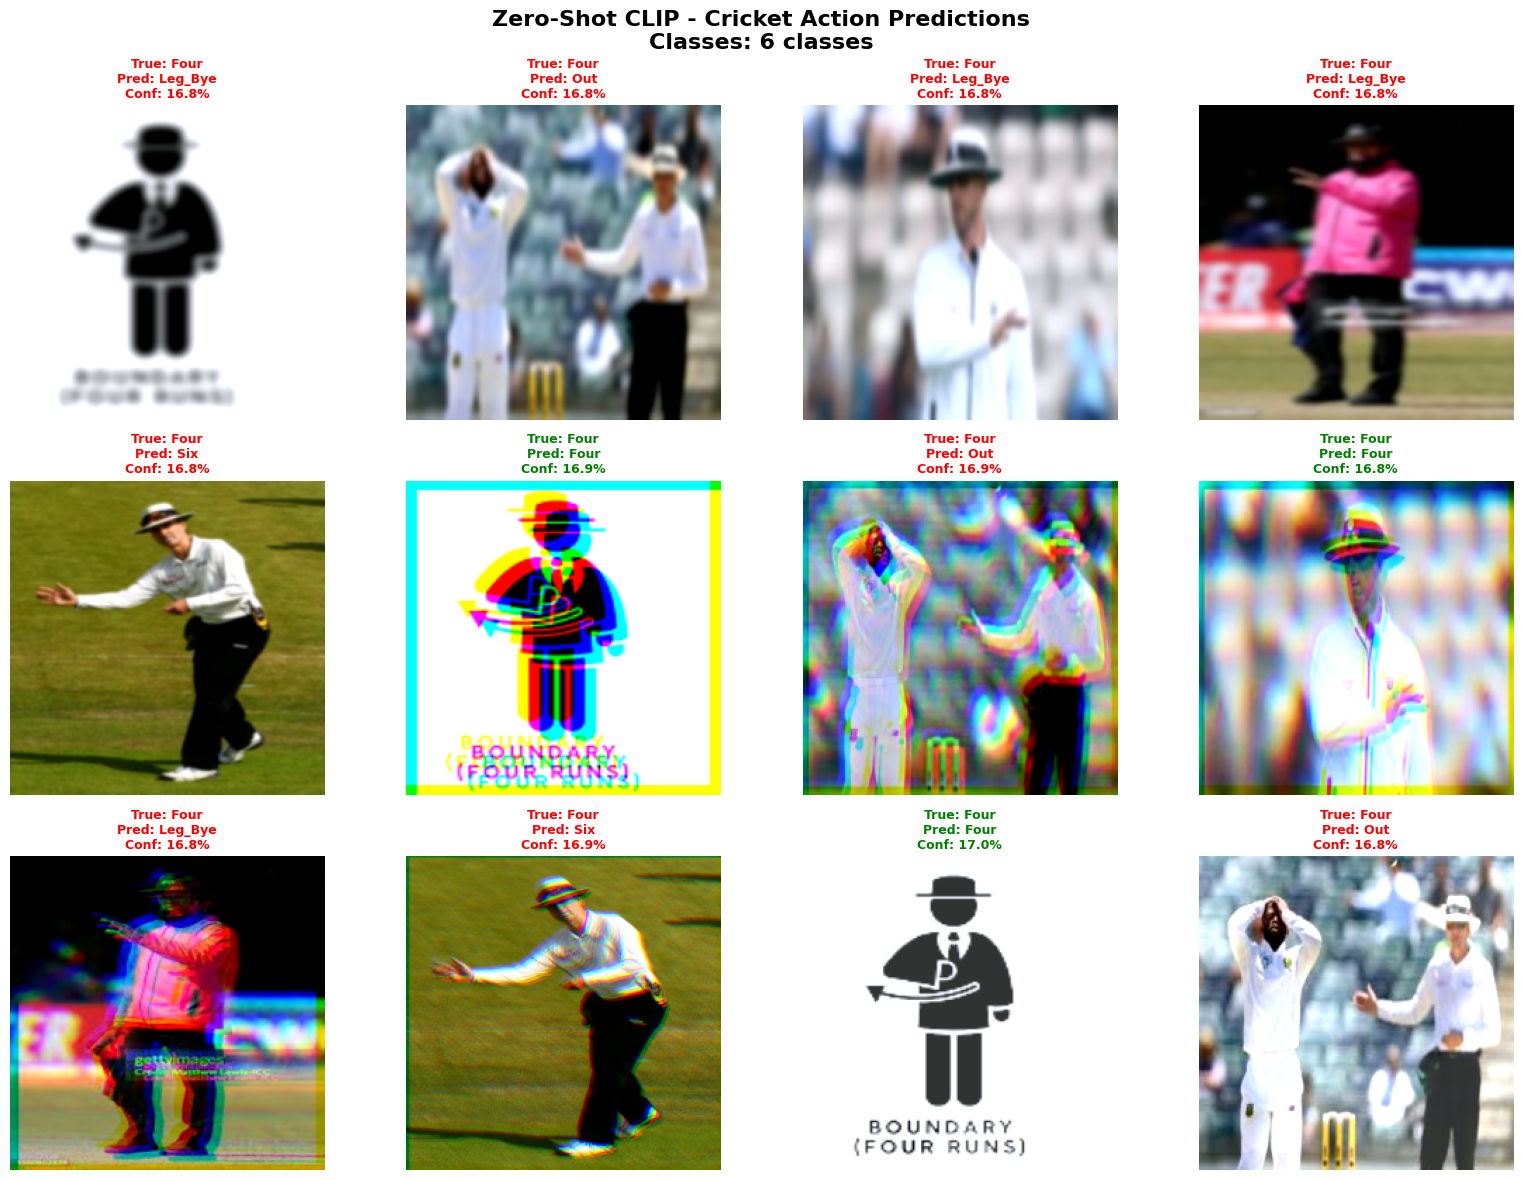

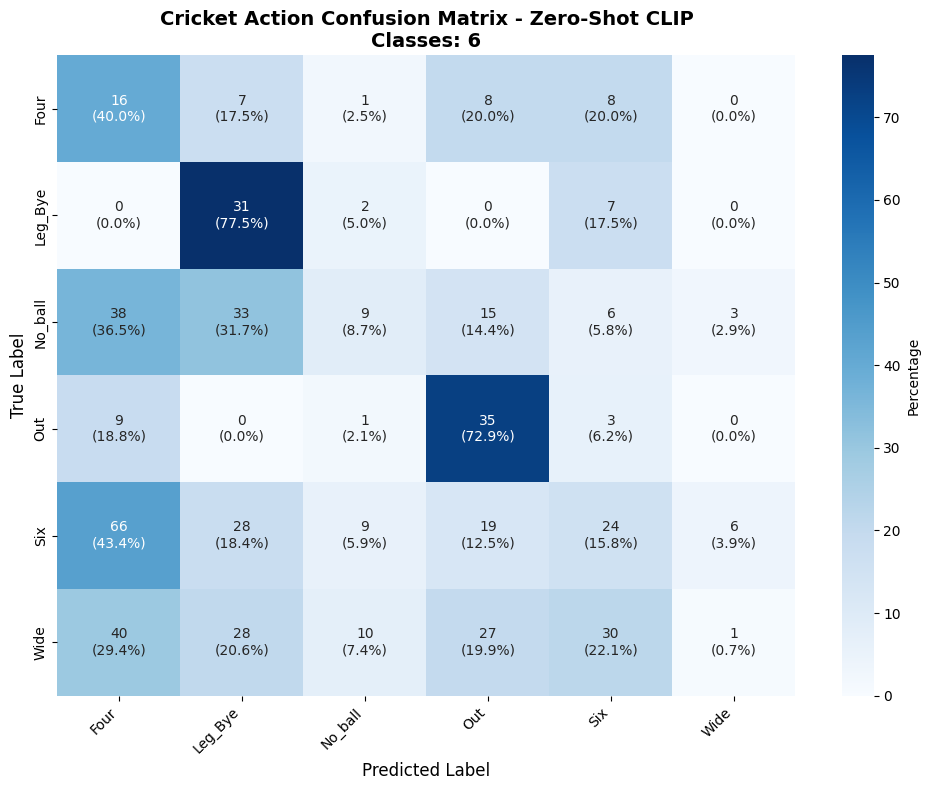


2️⃣ PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)
🔧 Converting CLIP model to float32...
✅ CLIP model converted to float32
📊 Trainable parameter dtypes (showing first few):
│ temperature: torch.float32
│ classifier.1.weight: torch.float32
│ classifier.1.bias: torch.float32
│ classifier.3.weight: torch.float32
│ classifier.3.bias: torch.float32
│ classifier.5.weight: torch.float32
│ classifier.5.bias: torch.float32
│ classifier.7.weight: torch.float32
🚀 Training CLIP Text Guided with Text Guidance...
📋 Using 6 text prompts for classes

📅 Epoch 1/50


Training: 100%|██████████| 48/48 [00:26<00:00,  1.83it/s, Loss=1.6904, Acc=30.79%]


✅ Best validation accuracy: 37.26%
📊 Train: 1.6904, 30.79% | Val: 1.6325, 37.26%

📅 Epoch 2/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=1.6231, Acc=36.07%]


📊 Train: 1.6231, 36.07% | Val: 1.7140, 31.49%

📅 Epoch 3/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.33it/s, Loss=1.4848, Acc=43.68%]


✅ Best validation accuracy: 55.29%
📊 Train: 1.4848, 43.68% | Val: 1.3580, 55.29%

📅 Epoch 4/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=1.4228, Acc=47.20%]


📊 Train: 1.4228, 47.20% | Val: 1.3566, 52.16%

📅 Epoch 5/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=1.3551, Acc=50.78%]


✅ Best validation accuracy: 69.95%
📊 Train: 1.3551, 50.78% | Val: 1.1300, 69.95%

📅 Epoch 6/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.36it/s, Loss=1.2817, Acc=54.75%]


📊 Train: 1.2817, 54.75% | Val: 1.2615, 64.18%

📅 Epoch 7/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.35it/s, Loss=1.2445, Acc=55.01%]


✅ Best validation accuracy: 72.12%
📊 Train: 1.2445, 55.01% | Val: 1.0723, 72.12%

📅 Epoch 8/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.32it/s, Loss=1.2212, Acc=58.59%]


📊 Train: 1.2212, 58.59% | Val: 1.0782, 71.15%

📅 Epoch 9/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.36it/s, Loss=1.1399, Acc=62.57%]


📊 Train: 1.1399, 62.57% | Val: 1.1654, 66.59%

📅 Epoch 10/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s, Loss=1.1231, Acc=63.74%]


📊 Train: 1.1231, 63.74% | Val: 1.2323, 62.74%

📅 Epoch 11/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.32it/s, Loss=1.1074, Acc=63.93%]


📊 Train: 1.1074, 63.93% | Val: 1.0996, 70.19%

📅 Epoch 12/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.32it/s, Loss=1.1082, Acc=62.24%]


✅ Best validation accuracy: 72.60%
📊 Train: 1.1082, 62.24% | Val: 1.0845, 72.60%

📅 Epoch 13/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=1.1036, Acc=63.22%]


✅ Best validation accuracy: 75.96%
📊 Train: 1.1036, 63.22% | Val: 1.0566, 75.96%

📅 Epoch 14/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.33it/s, Loss=1.0701, Acc=64.91%]


📊 Train: 1.0701, 64.91% | Val: 1.1193, 70.67%

📅 Epoch 15/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s, Loss=1.0659, Acc=65.76%]


📊 Train: 1.0659, 65.76% | Val: 1.0730, 73.80%

📅 Epoch 16/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s, Loss=1.0841, Acc=64.45%]


📊 Train: 1.0841, 64.45% | Val: 1.0752, 74.76%

📅 Epoch 17/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.22it/s, Loss=1.0596, Acc=65.62%]


📊 Train: 1.0596, 65.62% | Val: 1.1269, 72.12%

📅 Epoch 18/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=1.0435, Acc=65.95%]


📊 Train: 1.0435, 65.95% | Val: 1.1311, 70.67%

📅 Epoch 19/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.32it/s, Loss=1.0380, Acc=65.89%]


📊 Train: 1.0380, 65.89% | Val: 1.0949, 73.32%

📅 Epoch 20/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, Loss=1.0421, Acc=64.97%]


📊 Train: 1.0421, 64.97% | Val: 1.0614, 75.48%

📅 Epoch 21/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.23it/s, Loss=1.0210, Acc=68.03%]


📊 Train: 1.0210, 68.03% | Val: 1.1425, 70.67%

📅 Epoch 22/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.02it/s, Loss=1.0362, Acc=66.41%]


📊 Train: 1.0362, 66.41% | Val: 1.1036, 73.08%

📅 Epoch 23/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.12it/s, Loss=1.0211, Acc=68.36%]


📊 Train: 1.0211, 68.36% | Val: 1.1149, 73.08%

📅 Epoch 24/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.20it/s, Loss=1.0140, Acc=68.23%]


📊 Train: 1.0140, 68.23% | Val: 1.1175, 72.36%

📅 Epoch 25/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.20it/s, Loss=1.0058, Acc=68.10%]


📊 Train: 1.0058, 68.10% | Val: 1.1233, 73.32%

📅 Epoch 26/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.18it/s, Loss=1.0224, Acc=66.86%]


📊 Train: 1.0224, 66.86% | Val: 1.1823, 70.91%

📅 Epoch 27/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.17it/s, Loss=1.0030, Acc=68.68%]


📊 Train: 1.0030, 68.68% | Val: 1.1232, 73.56%

📅 Epoch 28/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, Loss=1.0065, Acc=68.68%]


📊 Train: 1.0065, 68.68% | Val: 1.1373, 72.12%

📅 Epoch 29/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.11it/s, Loss=1.0052, Acc=68.49%]


📊 Train: 1.0052, 68.49% | Val: 1.1083, 75.00%

📅 Epoch 30/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.15it/s, Loss=1.0040, Acc=68.10%]


📊 Train: 1.0040, 68.10% | Val: 1.1047, 74.04%

📅 Epoch 31/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.23it/s, Loss=1.0095, Acc=67.64%]


📊 Train: 1.0095, 67.64% | Val: 1.1007, 74.28%

📅 Epoch 32/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, Loss=0.9931, Acc=68.62%]


📊 Train: 0.9931, 68.62% | Val: 1.1035, 74.04%

📅 Epoch 33/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.13it/s, Loss=1.0033, Acc=68.36%]


📊 Train: 1.0033, 68.36% | Val: 1.1048, 73.32%

📅 Epoch 34/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.19it/s, Loss=1.0033, Acc=67.71%]


📊 Train: 1.0033, 67.71% | Val: 1.1093, 75.00%

📅 Epoch 35/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.24it/s, Loss=0.9885, Acc=69.01%]


📊 Train: 0.9885, 69.01% | Val: 1.0940, 74.28%

📅 Epoch 36/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.14it/s, Loss=0.9913, Acc=68.29%]


📊 Train: 0.9913, 68.29% | Val: 1.0825, 73.56%

📅 Epoch 37/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.24it/s, Loss=1.0023, Acc=68.88%]


📊 Train: 1.0023, 68.88% | Val: 1.0825, 73.56%

📅 Epoch 38/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.22it/s, Loss=0.9963, Acc=68.68%]


📊 Train: 0.9963, 68.68% | Val: 1.1201, 72.12%

📅 Epoch 39/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.13it/s, Loss=0.9851, Acc=69.08%]


📊 Train: 0.9851, 69.08% | Val: 1.1013, 72.36%

📅 Epoch 40/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, Loss=1.0034, Acc=67.58%]


📊 Train: 1.0034, 67.58% | Val: 1.0942, 72.12%

📅 Epoch 41/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s, Loss=0.9931, Acc=70.57%]


📊 Train: 0.9931, 70.57% | Val: 1.0898, 73.80%

📅 Epoch 42/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.31it/s, Loss=0.9841, Acc=69.60%]


📊 Train: 0.9841, 69.60% | Val: 1.0890, 73.32%

📅 Epoch 43/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.29it/s, Loss=1.0005, Acc=68.10%]


📊 Train: 1.0005, 68.10% | Val: 1.0815, 74.28%

📅 Epoch 44/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.26it/s, Loss=0.9874, Acc=68.62%]


📊 Train: 0.9874, 68.62% | Val: 1.0864, 73.32%

📅 Epoch 45/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.25it/s, Loss=0.9943, Acc=68.55%]


📊 Train: 0.9943, 68.55% | Val: 1.0828, 75.00%

📅 Epoch 46/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s, Loss=1.0012, Acc=68.49%]


📊 Train: 1.0012, 68.49% | Val: 1.0814, 72.84%

📅 Epoch 47/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.22it/s, Loss=0.9957, Acc=68.29%]


📊 Train: 0.9957, 68.29% | Val: 1.0936, 74.52%

📅 Epoch 48/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.30it/s, Loss=0.9929, Acc=70.31%]


📊 Train: 0.9929, 70.31% | Val: 1.1032, 73.80%

📅 Epoch 49/50


Training: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, Loss=0.9966, Acc=68.23%]


📊 Train: 0.9966, 68.23% | Val: 1.0786, 73.80%

📅 Epoch 50/50


Training: 100%|██████████| 48/48 [00:15<00:00,  3.15it/s, Loss=0.9933, Acc=68.36%]


📊 Train: 0.9933, 68.36% | Val: 1.0857, 74.04%
✅ Loaded best_clip_text_guided_text.pth for evaluation

🔍 Evaluating CLIP Text Guided...
📋 Classes: 6 classes


Testing: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


🎯 CLIP Text Guided Accuracy: 0.6019 (60.19%)
📋 Classification Report:
              precision    recall  f1-score   support

        Four     0.0526    0.0250    0.0339        40
     Leg_Bye     0.7667    0.5750    0.6571        40
     No_ball     0.4118    0.5385    0.4667       104
         Out     0.5818    0.6667    0.6214        48
         Six     0.8438    0.8882    0.8654       152
        Wide     0.5500    0.4853    0.5156       136

    accuracy                         0.6019       520
   macro avg     0.5344    0.5298    0.5267       520
weighted avg     0.5896    0.6019    0.5917       520



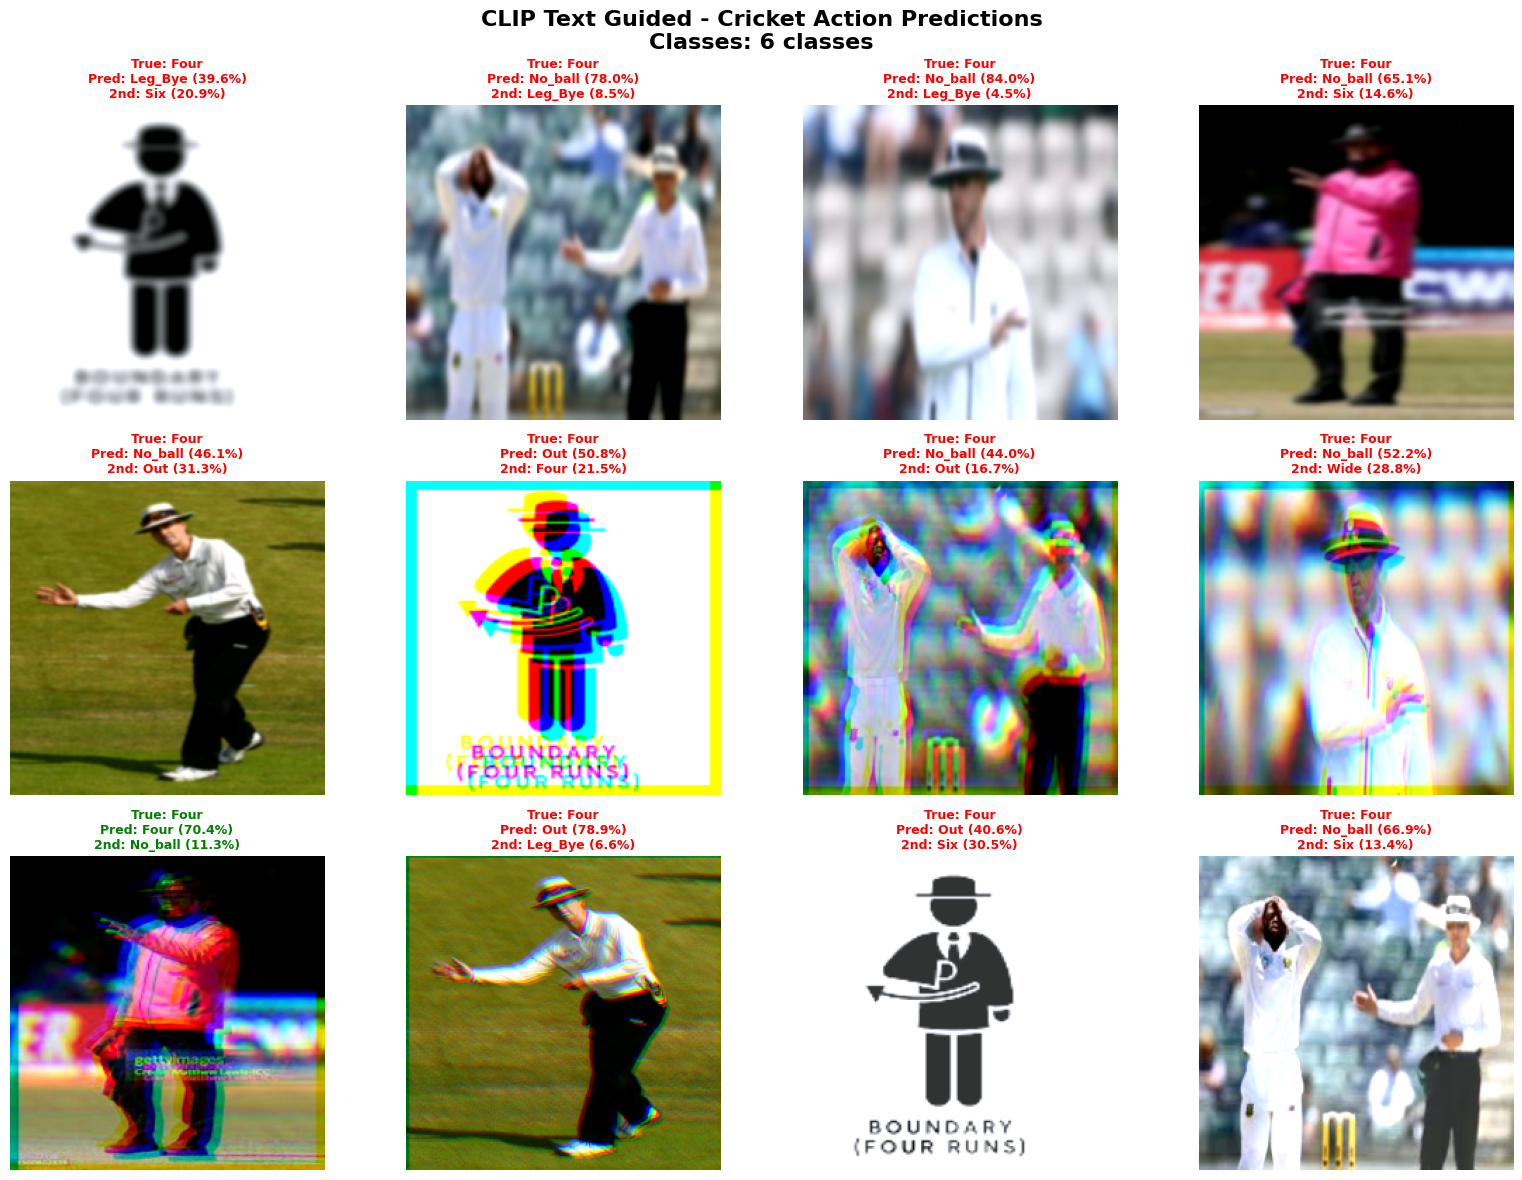

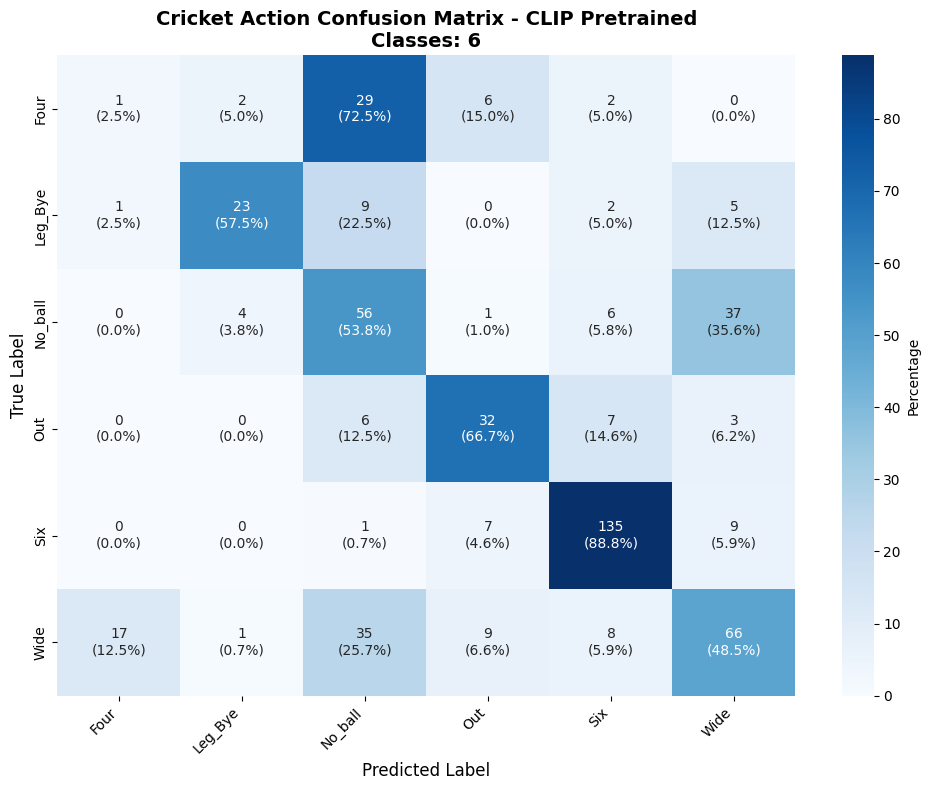


3️⃣ VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION
🚀 Training ViT Text Supervised with Text Supervision...

📅 Epoch 1/50


Training: 100%|██████████| 48/48 [00:30<00:00,  1.60it/s, Loss=1.6724, Acc=28.65%]


✅ Best validation accuracy: 31.49%
📊 Train Acc: 28.65% | Val Acc: 31.49%

📅 Epoch 2/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=1.6243, Acc=36.85%]


✅ Best validation accuracy: 33.41%
📊 Train Acc: 36.85% | Val Acc: 33.41%

📅 Epoch 3/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=1.5278, Acc=42.32%]


✅ Best validation accuracy: 34.62%
📊 Train Acc: 42.32% | Val Acc: 34.62%

📅 Epoch 4/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=1.3079, Acc=55.01%]


📊 Train Acc: 55.01% | Val Acc: 31.01%

📅 Epoch 5/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=1.1159, Acc=65.89%]


✅ Best validation accuracy: 45.43%
📊 Train Acc: 65.89% | Val Acc: 45.43%

📅 Epoch 6/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.8549, Acc=80.60%]


📊 Train Acc: 80.60% | Val Acc: 41.11%

📅 Epoch 7/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.7914, Acc=82.94%]


📊 Train Acc: 82.94% | Val Acc: 39.18%

📅 Epoch 8/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.6690, Acc=89.13%]


📊 Train Acc: 89.13% | Val Acc: 36.06%

📅 Epoch 9/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.6032, Acc=92.38%]


✅ Best validation accuracy: 45.67%
📊 Train Acc: 92.38% | Val Acc: 45.67%

📅 Epoch 10/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.5493, Acc=94.14%]


📊 Train Acc: 94.14% | Val Acc: 35.34%

📅 Epoch 11/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.5478, Acc=94.66%]


📊 Train Acc: 94.66% | Val Acc: 37.02%

📅 Epoch 12/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4876, Acc=97.33%]


📊 Train Acc: 97.33% | Val Acc: 41.11%

📅 Epoch 13/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4999, Acc=96.74%]


📊 Train Acc: 96.74% | Val Acc: 39.42%

📅 Epoch 14/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4952, Acc=97.33%]


📊 Train Acc: 97.33% | Val Acc: 43.99%

📅 Epoch 15/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s, Loss=0.4818, Acc=97.66%]


📊 Train Acc: 97.66% | Val Acc: 43.99%

📅 Epoch 16/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s, Loss=0.4794, Acc=97.79%]


✅ Best validation accuracy: 46.39%
📊 Train Acc: 97.79% | Val Acc: 46.39%

📅 Epoch 17/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4736, Acc=97.72%]


📊 Train Acc: 97.72% | Val Acc: 41.83%

📅 Epoch 18/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s, Loss=0.4469, Acc=98.96%]


📊 Train Acc: 98.96% | Val Acc: 42.79%

📅 Epoch 19/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4431, Acc=99.15%]


📊 Train Acc: 99.15% | Val Acc: 42.31%

📅 Epoch 20/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4441, Acc=99.22%]


✅ Best validation accuracy: 46.63%
📊 Train Acc: 99.22% | Val Acc: 46.63%

📅 Epoch 21/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4546, Acc=98.63%]


📊 Train Acc: 98.63% | Val Acc: 39.66%

📅 Epoch 22/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s, Loss=0.4392, Acc=99.41%]


📊 Train Acc: 99.41% | Val Acc: 45.19%

📅 Epoch 23/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4305, Acc=99.67%]


📊 Train Acc: 99.67% | Val Acc: 44.71%

📅 Epoch 24/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4437, Acc=99.15%]


📊 Train Acc: 99.15% | Val Acc: 45.43%

📅 Epoch 25/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4331, Acc=99.54%]


📊 Train Acc: 99.54% | Val Acc: 45.43%

📅 Epoch 26/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4326, Acc=99.61%]


✅ Best validation accuracy: 48.56%
📊 Train Acc: 99.61% | Val Acc: 48.56%

📅 Epoch 27/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s, Loss=0.4308, Acc=99.74%]


📊 Train Acc: 99.74% | Val Acc: 45.43%

📅 Epoch 28/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4285, Acc=99.74%]


📊 Train Acc: 99.74% | Val Acc: 44.95%

📅 Epoch 29/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4286, Acc=99.80%]


📊 Train Acc: 99.80% | Val Acc: 46.88%

📅 Epoch 30/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4242, Acc=99.93%]


📊 Train Acc: 99.93% | Val Acc: 47.36%

📅 Epoch 31/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4222, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 46.15%

📅 Epoch 32/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4243, Acc=99.93%]


📊 Train Acc: 99.93% | Val Acc: 47.84%

📅 Epoch 33/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4220, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 46.63%

📅 Epoch 34/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s, Loss=0.4220, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 46.39%

📅 Epoch 35/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4220, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.67%

📅 Epoch 36/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4227, Acc=99.93%]


📊 Train Acc: 99.93% | Val Acc: 46.39%

📅 Epoch 37/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4235, Acc=99.93%]


📊 Train Acc: 99.93% | Val Acc: 46.15%

📅 Epoch 38/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 46.15%

📅 Epoch 39/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4220, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 44.95%

📅 Epoch 40/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.43%

📅 Epoch 41/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.43%

📅 Epoch 42/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.68it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.43%

📅 Epoch 43/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4220, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.19%

📅 Epoch 44/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4218, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 44.71%

📅 Epoch 45/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 44.95%

📅 Epoch 46/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 44.95%

📅 Epoch 47/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.19%

📅 Epoch 48/50


Training: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.19%

📅 Epoch 49/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.19%

📅 Epoch 50/50


Training: 100%|██████████| 48/48 [00:28<00:00,  1.67it/s, Loss=0.4219, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 45.19%
✅ Loaded best_vit_text_supervised.pth for evaluation

🔍 Evaluating ViT Text Supervised...
📋 Classes: 6 classes


Testing: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


🎯 ViT Text Supervised Accuracy: 0.2962 (29.62%)
📋 Classification Report:
              precision    recall  f1-score   support

        Four     0.0000    0.0000    0.0000        40
     Leg_Bye     0.1417    0.4500    0.2156        40
     No_ball     0.1905    0.1154    0.1437       104
         Out     0.0000    0.0000    0.0000        48
         Six     0.4054    0.3947    0.4000       152
        Wide     0.4885    0.4706    0.4794       136

    accuracy                         0.2962       520
   macro avg     0.2044    0.2385    0.2064       520
weighted avg     0.2953    0.2962    0.2876       520



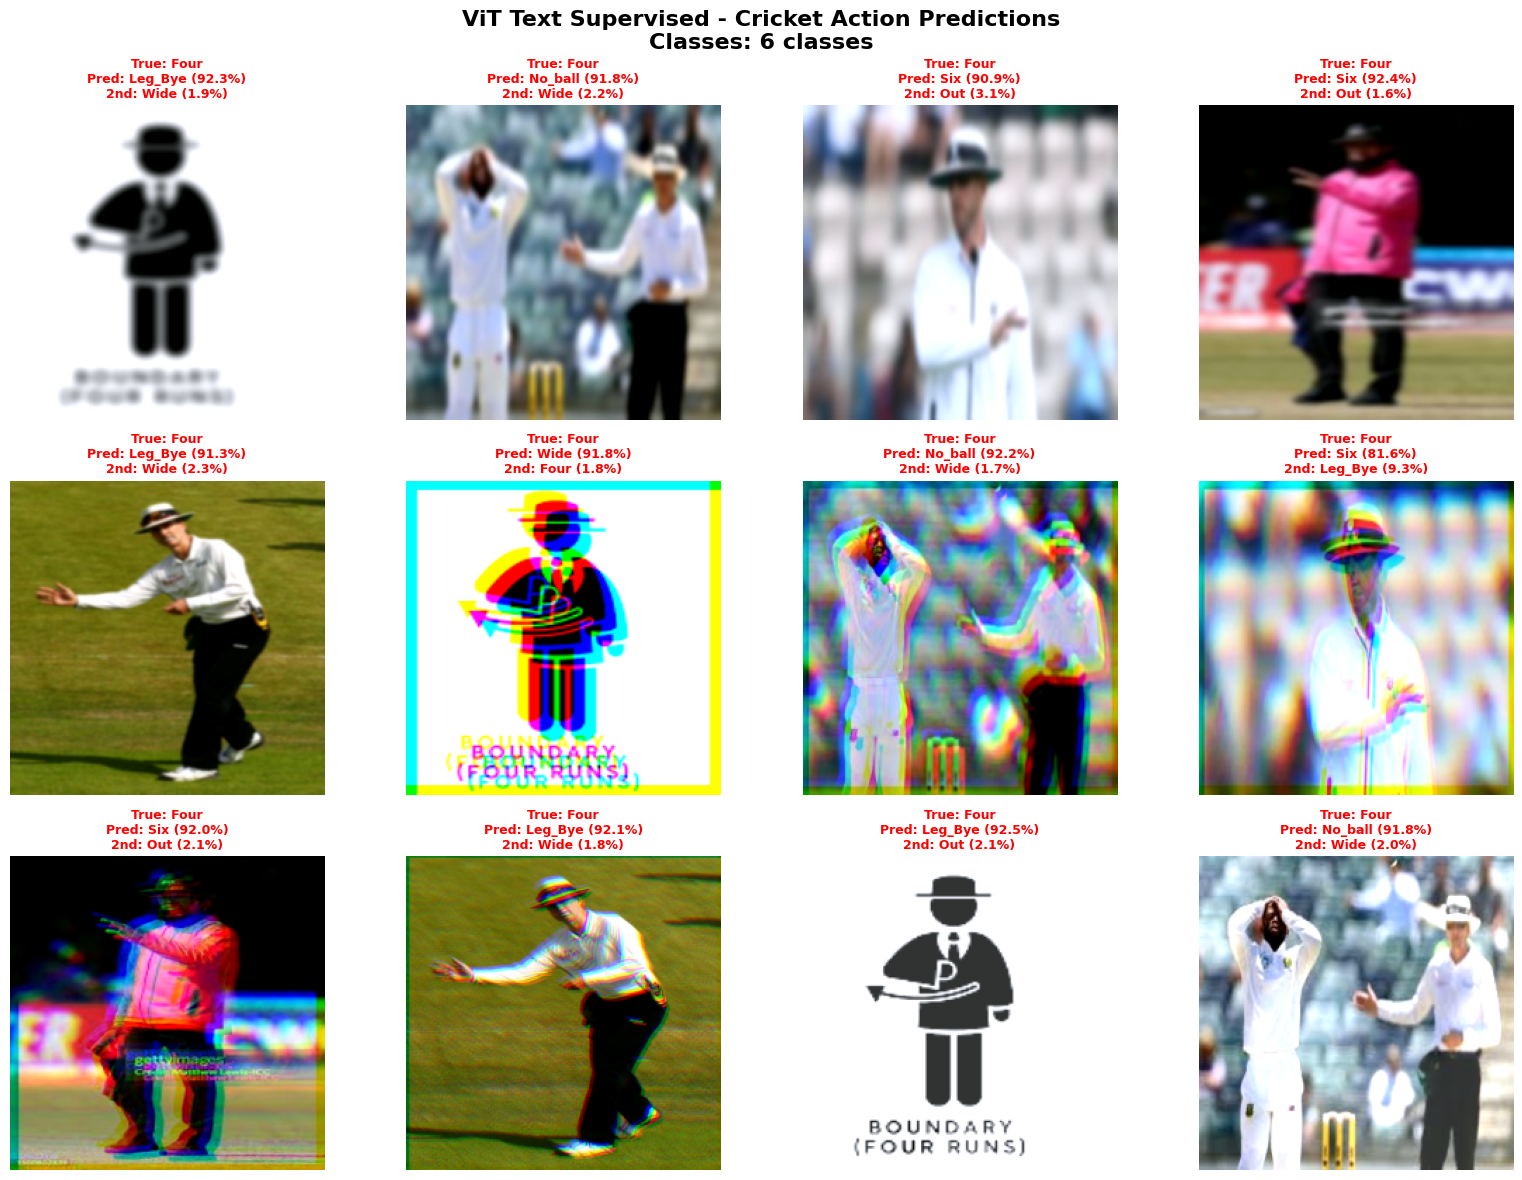

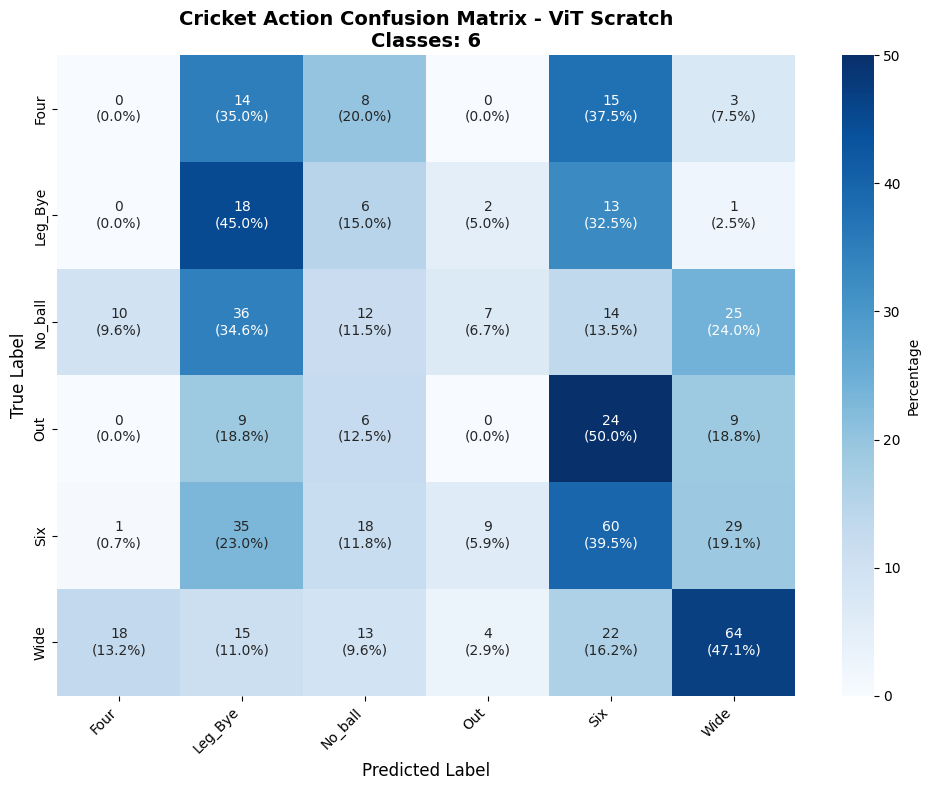


📊 FINAL RESULTS - CRICKET ACTION CLASSIFICATION (DTYPE FIXED)


/tmp/ipykernel_19/3376567679.py:823: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


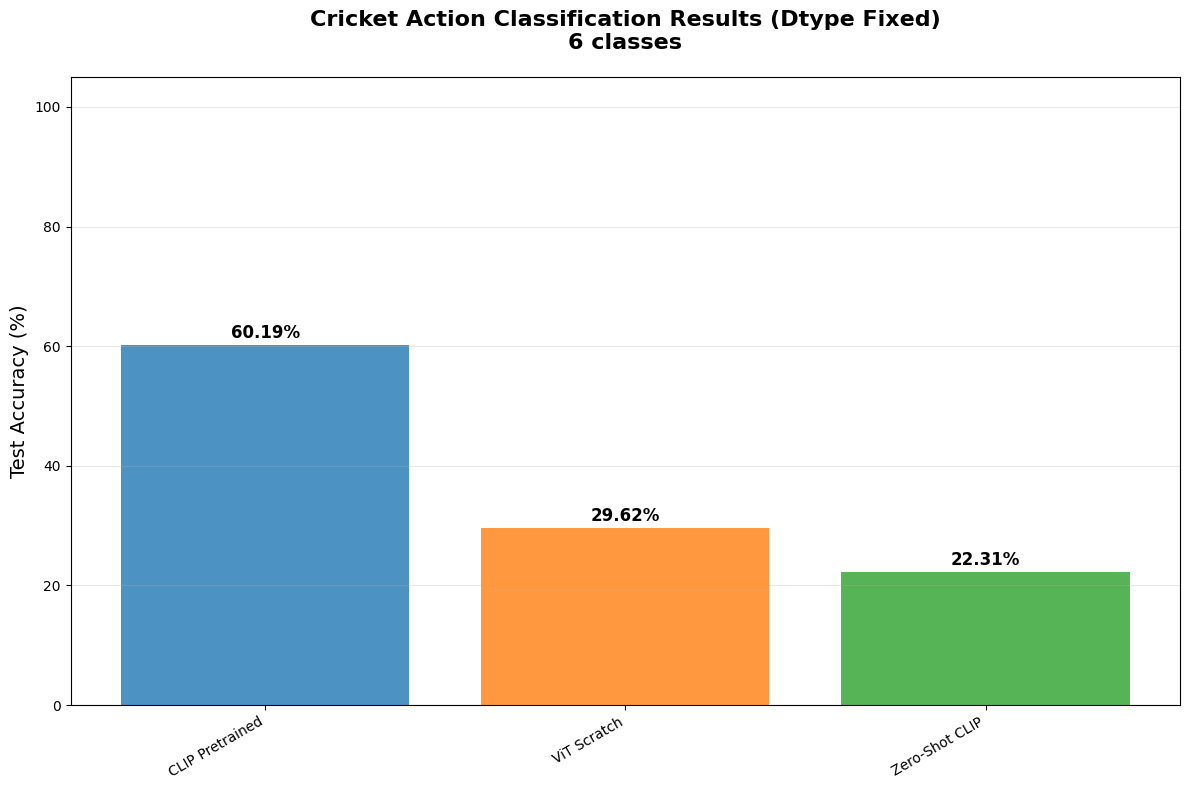

🏆 FINAL RANKINGS:
🥇 CLIP Pretrained: 0.6019 (60.19%)
🥈 ViT Scratch: 0.2962 (29.62%)
🥉 Zero-Shot CLIP: 0.2231 (22.31%)

📈 Performance Range: 169.83% improvement from worst to best

✨ TEXT ENHANCEMENT BENEFITS:
│ 🎯 Semantic Understanding: Models learn explicit action descriptions
│ 🔄 Multi-Modal Learning: Combines visual and textual information
│ 📈 Better Generalization: Text guidance improves robustness
│ 🎨 Interpretability: Clear text-image associations
│ 🚀 Faster Convergence: Text supervision accelerates learning

✅ Cricket Action Classification Complete (DType Fixed)!
🔧 All dtype mismatches resolved
📋 Classes processed: 6
📁 Generated Files (examples):
│ zero-shot_clip_cricket_predictions.png
│ clip_text_guided_cricket_predictions.png
│ vit_text_supervised_cricket_predictions.png
│ zero-shot_clip_confusion_matrix.png
│ clip_pretrained_confusion_matrix.png
│ vit_scratch_confusion_matrix.png
│ cricket_action_final_results_fixed.png


In [9]:
results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)